In [1]:
# Ставим библиотеку detecto и библиотеку для сбора списка установленных модулей.
!pip install detecto
!pip install session-info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=7aa2dbd4b9435c51443827b2808a4c319b268816f895a5566d21622e26cc5e93
  Stored in directory: /root/.cache/pip/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info


In [2]:
#  Импортируем модули. 

import torch
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import session_info

In [5]:
# Подключаем гугл диск, где хранится датасет и разметка.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Выведем версии используемых модулей. Версия detecto отобразилась при установке detecto==1.2.2 
session_info.show()

In [ ]:
# Разархивируем архив detecto.zip содержащий папки с картинками и разметкой для обучения и валидации.
!unzip /content/drive/My\ Drive/detecto.zip -d /content/drive/My\ Drive/

Archive:  /content/drive/My Drive/detecto.zip
   creating: /content/drive/My Drive/detecto/
   creating: /content/drive/My Drive/detecto/model/
   creating: /content/drive/My Drive/detecto/train/
  inflating: /content/drive/My Drive/detecto/train/11_6_2014_19_14_5_514_0.png  
  inflating: /content/drive/My Drive/detecto/train/12_6_2014_19_50_8_30_0.png  
  inflating: /content/drive/My Drive/detecto/train/21_5_2014_19_47_19_971_0.png  
  inflating: /content/drive/My Drive/detecto/train/21_5_2014_20_14_10_742_0.png  
  inflating: /content/drive/My Drive/detecto/train/21_5_2014_20_4_33_361_0.png  
  inflating: /content/drive/My Drive/detecto/train/A300AX76.png  
  inflating: /content/drive/My Drive/detecto/train/A318BO76.png  
  inflating: /content/drive/My Drive/detecto/train/A398TH27.png  
  inflating: /content/drive/My Drive/detecto/train/A398XB198.png  
  inflating: /content/drive/My Drive/detecto/train/A399AE147.png  
  inflating: /content/drive/My Drive/detecto/train/A399AE39.png  


In [ ]:
# Преобразование изображения в тензор и нормализация
custom_transforms = transforms.Compose([
transforms.ToTensor(),
utils.normalize_transform(),
])

In [ ]:
%cd /content/drive/MyDrive
root_dir = Path().cwd()
print(root_dir)

/content/drive/MyDrive
/content/drive/MyDrive


In [ ]:
#print(os.listdir('detecto/training_labels/'))
# Пути к разметкам трейновой и валидационной части датасета
path_to_train_labels = str(root_dir.joinpath(root_dir, 'detecto/training_labels/'))     
path_to_val_labels = str(root_dir.joinpath(root_dir,'detecto/validation_labels/'))
path_to_csv_train = str(root_dir.joinpath(root_dir,'train.csv'))
path_to_csv_val = str(root_dir.joinpath(root_dir,'val.csv'))

# Преобразование множества файлов разметки в один файл формата csv 
utils.xml_to_csv(path_to_train_labels, path_to_csv_train)
utils.xml_to_csv(path_to_val_labels, path_to_csv_val)


# Пути к папкам с картинками для обучения и валидации
path_to_train_img = root_dir.joinpath(root_dir,'detecto/train/')
path_to_val_img = root_dir.joinpath(root_dir,'detecto/val/')

In [ ]:
# Создание объектов датасета, чтение и преобразовние картинок
train_dataset = core.Dataset(path_to_csv_train, path_to_train_img, transform = custom_transforms)
val_dataset = core.Dataset(path_to_csv_val, path_to_val_img)

loader = core.DataLoader(train_dataset, batch_size=2, shuffle=True)

# Укажем какие классы у нас есть (метки классов)
labels = ['0','1','2','3','4','5','6','7','8','9', 'А', 'В', 'С', 'Е', 'Н', 'К', 'М', 'О', 'Р', 'Т', 'Х', 'У']

# Загрузим в модель метки
model = core.Model(labels)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# Функция для обучения модели с разными параметрами
def model_train(epochs_number, lr, wd, lr_st, number_of_experiment ):
  losses = model.fit(loader, val_dataset, epochs=epochs_number, learning_rate=lr, weight_decay=wd, lr_step_size=lr_st ,verbose=True)

  # Путь по которому будем сохранять веса дообученной модели в зависимости от номера эксперимента.
  path_to_weights = root_dir.joinpath(root_dir, 'detecto/model/model_weights_'+str(number_of_experiment)+ '.pth')
  model.save(path_to_weights)
  
  # Выведем график лосса
  plt.plot(losses)
  plt.title("График лосса")
  plt.show()


Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:06<00:00,  3.77it/s]


Loss: 1.5406490755081177
Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:20<00:00,  3.89it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 14.29it/s]


Loss: 1.0102181625366211
Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:21<00:00,  3.79it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 14.41it/s]


Loss: 0.7166002988815308
Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:21<00:00,  3.78it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 14.19it/s]


Loss: 0.5994763922691345
Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:21<00:00,  3.75it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 14.27it/s]


Loss: 0.5683613431453705
Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:21<00:00,  3.71it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 14.38it/s]


Loss: 0.5600774669647217
Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:21<00:00,  3.69it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 14.25it/s]


Loss: 0.5477457141876221
Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:21<00:00,  3.64it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 14.08it/s]


Loss: 0.5453183829784394
Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.63it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 14.07it/s]


Loss: 0.5371221959590912
Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [00:21<00:00,  3.64it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.93it/s]


Loss: 0.5373323678970336


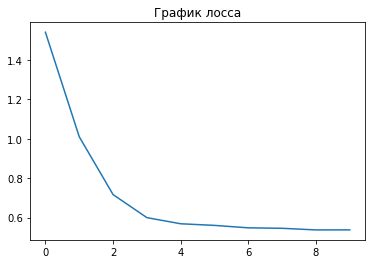

Epoch 1 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.61it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.90it/s]


Loss: 0.619854347705841
Epoch 2 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.61it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.68it/s]


Loss: 0.4871444034576416
Epoch 3 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.60it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.85it/s]


Loss: 0.3955169630050659
Epoch 4 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.81it/s]


Loss: 0.3885870385169983
Epoch 5 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.75it/s]


Loss: 0.38715441346168517
Epoch 6 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.77it/s]


Loss: 0.37915476262569425
Epoch 7 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.66it/s]


Loss: 0.3777557736635208
Epoch 8 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.76it/s]


Loss: 0.38365627110004424
Epoch 9 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.71it/s]


Loss: 0.3811250197887421
Epoch 10 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.89it/s]


Loss: 0.3777412694692612
Epoch 11 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.71it/s]


Loss: 0.38429722905159
Epoch 12 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.89it/s]


Loss: 0.3842266136407852
Epoch 13 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.71it/s]


Loss: 0.3814640563726425
Epoch 14 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.64it/s]


Loss: 0.3777091133594513
Epoch 15 of 15
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.74it/s]


Loss: 0.3853573250770569


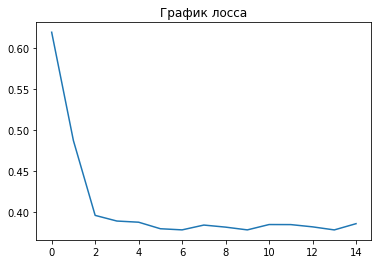

Epoch 1 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.55it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.65it/s]


Loss: 0.5480232441425323
Epoch 2 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.78it/s]


Loss: 0.3779934829473495
Epoch 3 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.70it/s]


Loss: 0.36553279459476473
Epoch 4 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.63it/s]


Loss: 0.3648302590847015
Epoch 5 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.88it/s]


Loss: 0.36661789417266843
Epoch 6 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.79it/s]


Loss: 0.3661115056276321
Epoch 7 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.73it/s]


Loss: 0.36794059216976166
Epoch 8 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.80it/s]


Loss: 0.3641756063699722
Epoch 9 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.96it/s]


Loss: 0.36776815533638
Epoch 10 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.99it/s]


Loss: 0.36444775938987733
Epoch 11 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.59it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.85it/s]


Loss: 0.365025572180748
Epoch 12 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.74it/s]


Loss: 0.3671730786561966
Epoch 13 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.82it/s]


Loss: 0.36544307351112365
Epoch 14 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.61it/s]


Loss: 0.36469431340694425
Epoch 15 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.60it/s]


Loss: 0.363255917429924
Epoch 16 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.82it/s]


Loss: 0.3624549567699432
Epoch 17 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.77it/s]


Loss: 0.3631679093837738
Epoch 18 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.01it/s]


Loss: 0.37083952605724335
Epoch 19 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.56it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.67it/s]


Loss: 0.36455770790576936
Epoch 20 of 20
Begin iterating over training dataset


100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


Begin iterating over validation dataset


100%|██████████| 25/25 [00:01<00:00, 13.84it/s]


Loss: 0.3635878998041153


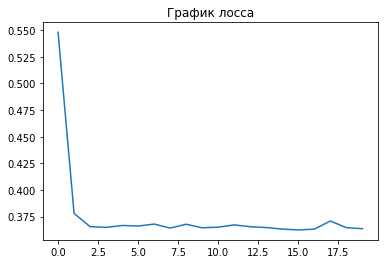

In [ ]:
# Обучим модель с разным количеством эпох, скоростью обучения, регуляризацией и шагом уменьшения скорости в порядке эксперимента.
# В документации к detecto не нашел ничего о возможности менять оптимизатор. 

# Количество эпох
epochs_number = [10, 15, 20]

# Скорость обучения
lr = [0.001, 0.003, 0.009]

# Регуляризация (weight_decay)
wd = [0.0005, 0.0001, 0.001]

# Шаг уменьшения скорости обучения
lr_st = [3, 2, 1]

for i in range(3):
  model_train(epochs_number[i], lr[i], wd[i], lr_st[i], i)

In [ ]:
# Видно, что learning_rate 0.001 и 0.003 оказались слишком маленькими.
#При learning_rate 0.009 лосс снижается быстрее (ожидаемо) и после 2 эпохи уже не сильно падает (первым двум для этого нужно 5-6 эпох).
# Не заметил чтобы регуляризация и изменение шагша скорости обучения сильно повлияли.
# Экспериментиовать можно очень долго, но бесплатный colab имеет ограничения.
# Не нашёл в документации к detecto описания, как менять оптимизатор. Возможно такой опции там нет.  Но я бы ещё попробовал другие оптимизаторы ради интереса.
